# RealNVP with KL-divergence loss

In [1]:
import torch
from torch import nn
from torch import distributions as dist
from torch.nn import functional as F
import numpy as np

Define the backbone networks `s`  and `t`, and the RealNVP model class. It's faster and slightly more accurate compared to subclassing with `dist.Transforms`.

In [9]:
def backbone(depth=3, width=32, s_net=True):
    layers = [nn.Linear(1, width),
              nn.LeakyReLU()]
    for _ in range(depth-2):
        layers += [nn.Linear(width, width),
                   nn.LeakyReLU()]
    layers += [nn.Linear(width, 1)]
    if s_net:
        layers += [nn.Tanh()]
    return nn.Sequential(*layers)

In [3]:
class RealNVP(nn.Module):
    def __init__(self, ncouplings=4, depth=3, width=32):
        super().__init__()
        self.ncouplings = ncouplings
        self.s = nn.ModuleList([backbone(depth, width, True) 
                                for _ in range(ncouplings)])
        self.t = nn.ModuleList([backbone(depth, width, False) 
                                for _ in range(ncouplings)])
        
        self.s_scale = torch.nn.ParameterList([torch.randn([]) 
                                               for _ in range(ncouplings)])
        
    def forward(self, x):
        # Assume x is sampled from random Gaussians
        s_vals = []
        y1, y2 = x[:, :1], x[:, 1:]
        for i in range(self.ncouplings):
            if i%2 == 0:
                x1, x2 = y1, y2
                y1 = x1
                s = self.s_scale[i]*self.s[i](x1)
                y2 = torch.exp(s)*x2 + self.t[i](x1)
            else:
                x1, x2 = y1, y2
                y2 = x2
                s = self.s_scale[i]*self.s[i](x2)
                y1 = torch.exp(s)*x1 + self.t[i](x2)
            s_vals.append(s)
        
        return torch.cat([y1, y2], 1), torch.cat(s_vals, 1).sum(1)

In [4]:
def loss_fn(target, y, x, logdetJ):
    # Target log probability
    logp_y1 = target.log_prob(y)
    # Model log probability
    logp_x = torch.sum(-(x**2)/2, dim=1)
    logp_y2 = logp_x - logdetJ
    # KL-divergence loss
    return torch.mean(logp_y2 - logp_y1)

In [5]:
def train(target, net: RealNVP, batch=50, 
          epochs=50, lr=0.02, device='cuda:0'):
    optimizer = torch.optim.Adam(net.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1000, 0.5)
    
    for ep in range(epochs):
        # Zero your gradients for every batch
        optimizer.zero_grad()
        # Obtain samples and logp of given batch size
        x = torch.randn([batch, 2], requires_grad=False, device=device)
        y, logdetJ = net(x)
        loss = loss_fn(target, y, x, logdetJ)
        loss.backward()
        # Gradient clipping
        # nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        # Adjust network parameters using optimizer and gradients
        optimizer.step()
        scheduler.step()

`loss_fn` evaluates the KL divergence between target distribution and model only upto a constant factor. Below function evaluates the true KL-divergence to evaluate the model fit.

In [6]:
def KL_div_true(target, net, batch=100, device='cuda:0'):
    x = torch.randn([batch, 2], requires_grad=False, device=device)
    y, logdetJ = net(x)
    logp_y1 = target.log_prob(y)
    logp_x = torch.sum(-(x**2)/2 - np.log(2*np.pi)/2, dim=1)
    logp_y2 = logp_x - logdetJ
    return (logp_y2 - logp_y1).mean()

## Multivariate Gaussian distribution

We'll model a bivariate gaussian of given mean vector and covariant matrix:

In [7]:
# Randomly selected means
mu = torch.zeros([2], device='cuda:0')
# Symmetric covariance matrix
cov = torch.tensor([[1.0, 0.8],
                    [0.8, 1.2]], device='cuda:0')
gauss = dist.MultivariateNormal(mu, cov)

In [10]:
# Initialize the network
net = RealNVP().to('cuda:0')

In [11]:
# Fit above distribution
train(gauss, net, 100, 4000, 1e-2)

In [12]:
# Evaluate the true KL divergence between target and model
KL_div_true(gauss, net)

tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>)

This is close to 0, which indicates convergence of the model distribution to the target.

## Mixture of gaussians

In [13]:
# Gaussian 1
mu1 = torch.tensor([0.5, -0.7], device='cuda:0')
cov1 = torch.tensor([[0.9, 0.6],
                    [0.6, 1.2]], device='cuda:0')
# Gaussian 2
mu2 = torch.tensor([-0.75, 0.6], device='cuda:0')
cov2 = torch.tensor([[0.8, 0.9],
                    [0.9, 1.5]], device='cuda:0')
# Combined distribution with batch_dim=0
comb = dist.MultivariateNormal(torch.stack([mu1, mu2], dim=0),
                               torch.stack([cov1, cov2], dim=0))

In [14]:
# Mixture distribution
cat = dist.Categorical(torch.full([2], 0.5, device='cuda:0'))
mix = dist.MixtureSameFamily(cat, comb)

We'll plot samples of this distribution:

In [15]:
import matplotlib.pyplot as plt

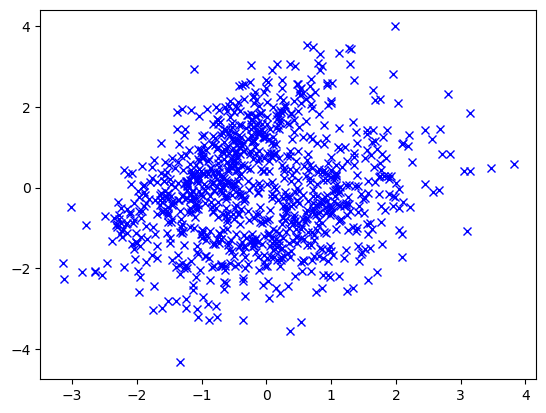

In [16]:
batch = 1000
device = 'cuda:0'

x = mix.sample([batch]).cpu()
x1, x2 = x[:, 0], x[:, 1]
plt.plot(x1, x2, 'x', color='blue', label="Target samples")

In [17]:
# New network
net2 = RealNVP(6, 4).to('cuda:0')

In [18]:
# Fit above distrbution
train(mix, net2, 100, 5000, 0.01)

In [19]:
# Evaluate the true KL divergence between target and model
KL_div_true(mix, net2)

tensor(0.0106, device='cuda:0', grad_fn=<MeanBackward0>)

This is close to 0, once again. Let's plot samples from the target distribution and model, then compare with each other:

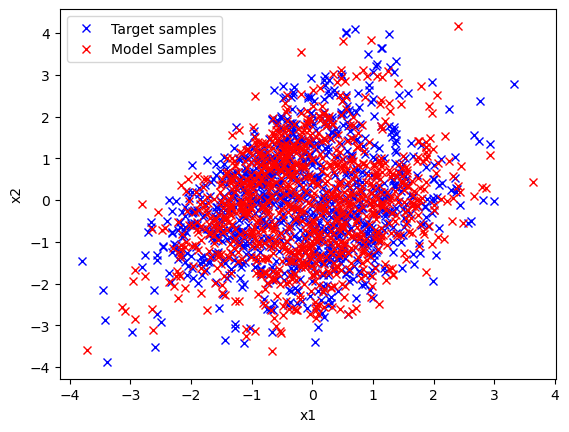

In [20]:
batch = 1000
device = 'cuda:0'

x = mix.sample([batch]).cpu()
x1, x2 = x[:, 0], x[:, 1]
plt.plot(x1, x2, 'x', color='blue', label="Target samples")

x = torch.randn([batch, 2], requires_grad=False, device=device)
y, logdetJ = net2(x)
y = y.detach().cpu()
y1, y2 = y[:, 0], y[:, 1]
plt.plot(y1, y2, 'x', color='red', label="Model Samples")

plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

The model and target distributions seem to yield similar samples as well. In this example, even though we used a mixture of 2 gaussian variables, there's some overlap between the two modes. What if we have two distinctly separate modes?

In [22]:
# Gaussian 1
mu1 = torch.tensor([2.5, -2.7], device='cuda:0')
cov1 = torch.tensor([[0.9, 0.6],
                    [0.6, 1.2]], device='cuda:0')
# Gaussian 2
mu2 = torch.tensor([-2.75, 3.6], device='cuda:0')
cov2 = torch.tensor([[0.8, 0.9],
                    [0.9, 1.5]], device='cuda:0')
# Combined distribution with batch_dim=0
comb = dist.MultivariateNormal(torch.stack([mu1, mu2], dim=0),
                               torch.stack([cov1, cov2], dim=0))

In [23]:
# Mixture distribution
cat = dist.Categorical(torch.full([2], 0.5, device='cuda:0'))
mix2 = dist.MixtureSameFamily(cat, comb)

Plotting this:

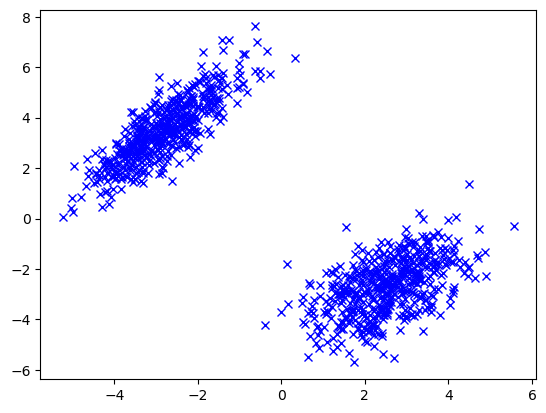

In [24]:
batch = 1000
device = 'cuda:0'

x = mix2.sample([batch]).cpu()
x1, x2 = x[:, 0], x[:, 1]
plt.plot(x1, x2, 'x', color='blue', label="Target samples")

In [25]:
# New network
net3 = RealNVP(6, 4).to('cuda:0')

In [26]:
# Fit above distrbution
train(mix2, net3, 100, 5000, 0.01)

In [27]:
# Evaluate the true KL divergence between target and model
KL_div_true(mix2, net3)

tensor(0.6902, device='cuda:0', grad_fn=<MeanBackward0>)

Is greater than zero. This indicates convergence to a local minimum rather than the global one. Let's plot and compare samples from both distributions:

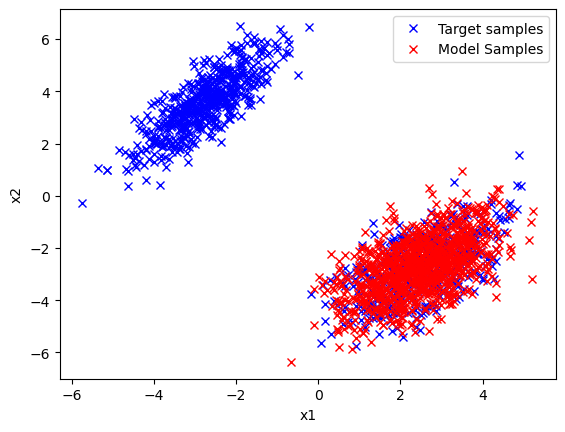

In [28]:
batch = 1000
device = 'cuda:0'

x = mix2.sample([batch]).cpu()
x1, x2 = x[:, 0], x[:, 1]
plt.plot(x1, x2, 'x', color='blue', label="Target samples")

x = torch.randn([batch, 2], requires_grad=False, device=device)
y, logdetJ = net3(x)
y = y.detach().cpu()
y1, y2 = y[:, 0], y[:, 1]
plt.plot(y1, y2, 'x', color='red', label="Model Samples")

plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

The samples from the model distribution only capture one of the distinct modes of the target distribution. This is not a problem with the real NVP ansatz since it's known to converge well on multimodal distributions. It's because the KL-divergence loss which only uses samples from the model distribution and then locally optimizes (using gradients) the target likelihood- an unsupervised learning technique. In popular applications like image generation, maximum likelihood loss is used, based on samples of the target distribution- a supervised learning technique.